## Probabalistic Data Labels

### Packages

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Model
from keras import optimizers
from keras.layers import Input, Dense, Dropout

### Importing Data

In [67]:
file_path = 'watchful_export.csv'
email_df = pd.read_csv(file_path)
email_df.head()

Text  Spam_Gold  Spam_Pred
0  Subject: longlasting erect " ions\r\nnew clall...          1        100
1  Subject: construção e reforma em 12 x\r\n( por...          1        100
2  Subject: get any medication , completely anony...          1        100
3  Subject: hi paliourg , we got hot , crazy and ...          1        100
4  Subject: board presentation\r\nplease find att...          0          1

In [68]:
email_df.describe()

Spam_Gold     Spam_Pred
count  33715.000000  33715.000000
mean       0.509269     51.300163
std        0.499921     46.838195
min        0.000000      0.000000
25%        0.000000      0.000000
50%        1.000000     76.000000
75%        1.000000    100.000000
max        1.000000    100.000000

### Exploring the Data

In [69]:
gold_col_name = 'Spam_Gold'
pred_col_name = 'Spam_Pred'
text_col_name = 'Text'

pct_spam = email_df[gold_col_name].sum() / email_df.shape[0]
pct_ham = 1 - pct_spam

pct_spam, pct_ham

(0.5092688714222157, 0.49073112857778434)

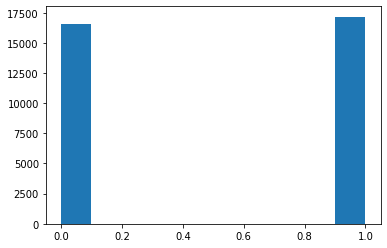

In [70]:
plt.hist(email_df[gold_col_name])
plt.show()

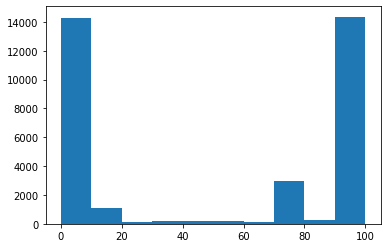

In [71]:
plt.hist(email_df[pred_col_name])
plt.show()

In [72]:
lengths = np.array([len(doc.split()) for doc in email_df[text_col_name]])

pd.DataFrame(lengths).describe()

0
count  33715.000000
mean     311.595017
std      851.434216
min        1.000000
25%       72.000000
50%      154.000000
75%      330.000000
max    45451.000000

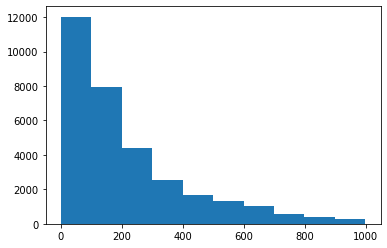

In [73]:
plt.hist(lengths[lengths < 1000])
plt.show()

In [74]:
vocabs = np.array([len(set(doc.split())) for doc in email_df[text_col_name]])

pd.DataFrame(vocabs).describe()

0
count  33715.000000
mean     131.714163
std      164.359126
min        1.000000
25%       52.000000
50%       90.000000
75%      158.000000
max     5184.000000

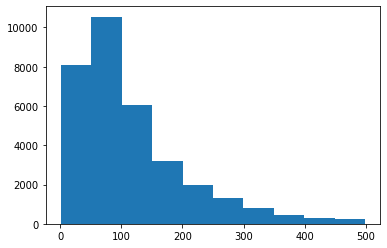

In [75]:
plt.hist(vocabs[vocabs < 500])
plt.show()

In [76]:
email_df[pred_col_name] = email_df[pred_col_name].apply(lambda r: 0 if r < 50 else 1)
accuracy_score(email_df[gold_col_name], email_df[pred_col_name], True)

0.9557467002817737

In [77]:
precision_recall_fscore_support(email_df[gold_col_name], email_df[pred_col_name])

(array([0.97584877, 0.9379819 ]),
 array([0.93291024, 0.97775189]),
 array([0.95389655, 0.95745409]),
 array([16545, 17170]))

## Method 1: Training on Thresholded Values (1=Spam, 0=Ham)

In [78]:
email_df = pd.read_csv(file_path)
email_df[pred_col_name] /= 100
email_df.head()

Text  Spam_Gold  Spam_Pred
0  Subject: longlasting erect " ions\r\nnew clall...          1       1.00
1  Subject: construção e reforma em 12 x\r\n( por...          1       1.00
2  Subject: get any medication , completely anony...          1       1.00
3  Subject: hi paliourg , we got hot , crazy and ...          1       1.00
4  Subject: board presentation\r\nplease find att...          0       0.01

In [79]:
df_train, df_test = train_test_split(email_df.sample(frac=1), test_size=0.2)

In [44]:
vec = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))

X_train = vec.fit_transform(df_train[text_col_name])
X_test = vec.transform(df_test[text_col_name])

ip_dim = X_train.shape[1]

In [62]:
X_train.shape

(26972, 141183)

In [45]:
#aaply 50% threshold to training set prob labels
y_train = np.stack([df_train[pred_col_name].apply(lambda r: 0 if r >= 0.5 else 1),
                    df_train[pred_col_name].apply(lambda r: 1 if r >= 0.5 else 0)], -1)
y_test = df_test[gold_col_name].to_numpy()

probs = df_train[pred_col_name].apply(lambda r: r if r > 0.5 else 1 - r).to_numpy()

In [57]:
y_train.shape

(26972, 2)

In [63]:
probs[100]

0.76

In [46]:
x = Input(shape=(ip_dim,))
h1 = Dense(128)(x)
h2 = Dense(64, activation='relu')(h1)
h3 = Dropout(0.1)(h2)
h4 = Dense(2, activation='softmax')(h3)

model = Model(inputs=x, outputs=h4)
model.compile(optimizers.Adam(0.00001), 'categorical_crossentropy', ['accuracy'])

In [47]:
model.fit(X_train, y_train, epochs=20, validation_split=0.15, sample_weight=probs)


Train on 22926 samples, validate on 4046 samples
Epoch 1/20
22926/22926 [==============================] - 395s 17ms/step - loss: 0.6208 - accuracy: 0.8708 - val_loss: 0.5609 - val_accuracy: 0.9288
Epoch 2/20
22926/22926 [==============================] - 332s 14ms/step - loss: 0.4811 - accuracy: 0.9486 - val_loss: 0.4070 - val_accuracy: 0.9464
Epoch 3/20
22926/22926 [==============================] - 318s 14ms/step - loss: 0.3316 - accuracy: 0.9592 - val_loss: 0.2794 - val_accuracy: 0.9535
Epoch 4/20
22926/22926 [==============================] - 327s 14ms/step - loss: 0.2243 - accuracy: 0.9629 - val_loss: 0.2004 - val_accuracy: 0.9567
Epoch 5/20
22926/22926 [==============================] - 334s 15ms/step - loss: 0.1601 - accuracy: 0.9656 - val_loss: 0.1558 - val_accuracy: 0.9570
Epoch 6/20
22926/22926 [==============================] - 345s 15ms/step - loss: 0.1225 - accuracy: 0.9675 - val_loss: 0.1304 - val_accuracy: 0.9577
Epoch 7/20
22926/22926 [==============================] 

In [49]:
y_pred = np.argmax(model.predict(X_test), -1)
accuracy_score(y_test, y_pred)

0.9755301794453507

In [64]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.99206601, 0.9610245 ]),
 array([0.95713411, 0.99280989]),
 array([0.97428705, 0.97665865]),
 array([3266, 3477]))

## Method 2: Train on complete probabilistic labels

In [81]:
vec = TfidfVectorizer(analyzer='word', ngram_range=(1, 1))

X_train = vec.fit_transform(df_train[text_col_name])
X_test = vec.transform(df_test[text_col_name])

ip_dim = X_train.shape[1]

In [82]:
y_train = np.stack([df_train[pred_col_name].apply(lambda r: 1 - r), df_train[pred_col_name]], -1)

y_test = df_test[gold_col_name].to_numpy()

In [90]:
x = Input(shape=(ip_dim,))
h1 = Dense(128)(x)
h2 = Dense(64, activation='relu')(h1)
h3 = Dropout(0.1)(h2)
h4 = Dense(2, activation='softmax')(h3)

model = Model(inputs=x, outputs=h4)
model.compile(optimizers.Adam(0.00001), 'kullback_leibler_divergence', ['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=20, validation_split=0.15)

Train on 22926 samples, validate on 4046 samples
Epoch 1/20
22926/22926 [==============================] - 351s 15ms/step - loss: 0.5515 - accuracy: 0.8971 - val_loss: 0.4900 - val_accuracy: 0.9530
Epoch 2/20
22926/22926 [==============================] - 361s 16ms/step - loss: 0.4146 - accuracy: 0.9566 - val_loss: 0.3396 - val_accuracy: 0.9565
Epoch 3/20
22926/22926 [==============================] - 367s 16ms/step - loss: 0.2691 - accuracy: 0.9612 - val_loss: 0.2183 - val_accuracy: 0.9587
Epoch 4/20
22926/22926 [==============================] - 355s 15ms/step - loss: 0.1716 - accuracy: 0.9633 - val_loss: 0.1484 - val_accuracy: 0.9597
Epoch 5/20
22926/22926 [==============================] - 365s 16ms/step - loss: 0.1177 - accuracy: 0.9646 - val_loss: 0.1126 - val_accuracy: 0.9597
Epoch 6/20
22926/22926 [==============================] - 316s 14ms/step - loss: 0.0889 - accuracy: 0.9669 - val_loss: 0.0941 - val_accuracy: 0.9605
Epoch 7/20
22926/22926 [==============================] -

In [85]:
y_pred = np.argmax(model.predict(X_test), -1)

In [86]:
accuracy_score(y_test, y_pred)

0.9734539522467744

In [87]:
precision_recall_fscore_support(y_test, y_pred)

(array([0.99684144, 0.9527537 ]),
 array([0.94917293, 0.99707431]),
 array([0.97242336, 0.97441029]),
 array([3325, 3418]))